# Hypotheses prioritization and A/B testing

Objective: Prioritize hypotheses prepared by online store marketers to increase revenue, run an A/B test, analyze the results and decide whether to continue the A/B test.
- First, we have to select the most promising hypotheses from the list of 9 hypotheses using ICE and RICE frameworks.
- Analyze the orders.csv and visitors.csv files that contain information about the A/B-test.
- Compare the revenue and number of orders between the two groups
- See if there are any anomalous values in the obtained data and analyze their impact
- Decide whether to suspend or continue A/B-testing

Three files are available:
- hypothesis.csv containing nine hypotheses and parameters Reach, Impact, Confidence и Effort
- orders.csv with information on each order (order id, user id, order's date, order's value, group)
- visitors.csv with information on the number of users by day (date, group, number of users)

In [1]:
#loading libraries
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
pd.options.display.max_colwidth = 100

In [2]:
try:
    hypothesis, orders, visitors = (
    pd.read_csv('hypothesis.csv'),
    pd.read_csv('orders.csv'),
    pd.read_csv('visitors.csv')
)
except FileNotFoundError:
    hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'),
    pd.read_csv('/datasets/orders.csv'),
    pd.read_csv('/datasets/visitors.csv')
)

## Hypotheses prioritization

To select the most promising hypotheses, we will use the ICE (I - how much the innovation will affect the user, C - confidence in the effect, E - complexity of the hypothesis realization) and RICE frameworks (additionally, the R indicator (coverage) is taken into account).

Applying ICE framework:

In [3]:
hypothesis['ICE'] = round(hypothesis['Impact'] * hypothesis['Confidence'] / 
                          hypothesis['Efforts'], 1)
display(hypothesis.sort_values(by='ICE', ascending=False))

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


The most promising hypotheses: 8, 0, 7, and 6.

Applying RICE framework:

In [4]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * 
                      hypothesis['Confidence']) / hypothesis['Efforts']
display(hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Hypotheses 7, 0, and 6 remain in the list of the most promising hypotheses:
- Add a subscription form to all main pages to gather a customers' base for email newsletters;
- Add two new traffic channels to attract 30% more users;
- Show banners with current promotions and sales on the homepage to increase conversion rates.  

However, instead of hypothesis 8, hypothesis 2 is at the top because hypothesis number 2's Reach score of 8 is much higher than hypothesis number 8.

## A/B test analysis

In [5]:
display(orders.head())
orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Information on 1,197 is available.  
No missing values.  
Datatype of 'date' column should be corrected.

In [6]:
# Correction of datatype in Orders table
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
display(orders.head())
orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [7]:
print('Timeframe:', min(orders['date']), '-', max(orders['date']))

Timeframe: 2019-08-01 00:00:00 - 2019-08-31 00:00:00


In [8]:
display(visitors.head())
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


There are total of 62 entries in 'visitors' file. Datatype also should be corrected.

In [9]:
# Correction of datatype in Visitors table
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [10]:
print('Timeframe:', min(visitors['date']), '-', max(visitors['date']))

Timeframe: 2019-08-01 00:00:00 - 2019-08-31 00:00:00


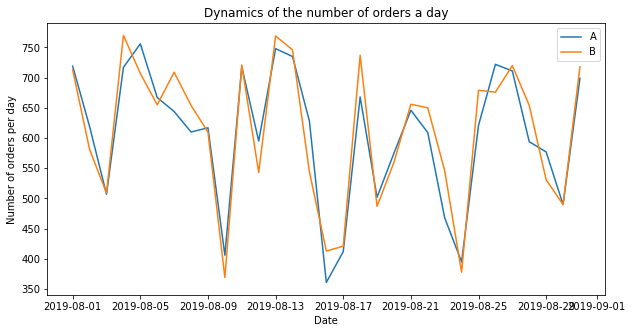

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(visitors[visitors['group']=='A']['date'], 
         visitors[visitors['group']=='A']['visitors'], 
         label='A')
plt.plot(visitors[visitors['group']=='B']['date'], 
         visitors[visitors['group']=='B']['visitors'], 
         label='B')

plt.ylabel('Number of orders per day')
plt.xlabel('Date')
plt.title('Dynamics of the number of orders a day')
plt.legend()

plt.show()

In [12]:
# Duplicates chack
print('Number of duplicates in the table Orders:', orders.duplicated().sum())
print('Number of duplicates in the table Visitors:', visitors.duplicated().sum())

Number of duplicates in the table Orders: 0
Number of duplicates in the table Visitors: 0


In [13]:
#Check if some users ended up in both groups
print(orders.groupby('visitorId').agg({'group':'nunique'}).query('group > 1').count())

group    58
dtype: int64


58 customers were found in both groups, A and B, representing 4.8% of the orders data. These anomalous records should be discarded as they may affect further analysis.

In [14]:
nonunique_cust = orders.groupby('visitorId').agg({'group':'nunique'}).query('group > 1')
nonunique_cust = nonunique_cust.index.to_list()
orders = orders.query('visitorId not in @nonunique_cust')
orders.groupby('visitorId').agg({'group':'nunique'}).query('group > 1').count()

group    0
dtype: int64

In [18]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [19]:
ordersAggregated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


In [20]:
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


### Cumulative revenue per group

In [15]:
# unique pairs "date-group"
datesGroups = orders[['date','group']].drop_duplicates()

# aggregated cumulative order data per day 
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(
        orders['date'] <= x['date'], 
        orders['group'] == x['group'])].agg({'date' : 'max',
                                             'group' : 'max',
                                             'transactionId' : 'nunique',
                                             'visitorId' : 'nunique',
                                             'revenue' : 'sum'}),
    axis=1).sort_values(by=['date','group'])

# aggregated cumulative visitors data per day
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(
        visitors['date'] <= x['date'],
        visitors['group'] == x['group'])].agg({'date' : 'max',
                                               'group' : 'max',
                                               'visitors' : 'sum'}),
    axis=1).sort_values(by=['date','group'])

# merging two dataframes
cumulativeData = ordersAggregated.merge(visitorsAggregated, 
                                        left_on=['date', 'group'], 
                                        right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


In [16]:
print('Timeframe:', min(cumulativeData['date']), '-', max(cumulativeData['date']))

Timeframe: 2019-08-01 00:00:00 - 2019-08-31 00:00:00


The timeframe in the merged dataframe matches the original data.

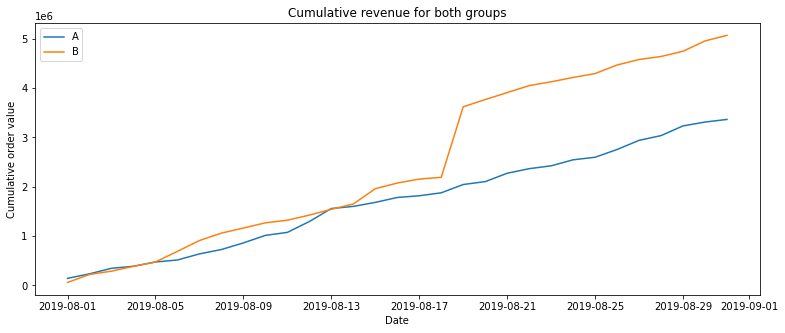

In [17]:
# number of orders and revenue in group A
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][
    ['date','revenue','orders']]

#number of orders and revenue in group B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][[
    'date','revenue', 'orders']]

#plotting cumulative revenue for two groups by day
plt.figure(figsize=(13, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.ylabel('Cumulative order value')
plt.xlabel('Date')
plt.title('Cumulative revenue for both groups')
plt.show()

Revenue increases for both groups throughout the test. However, Group B shows a sharp increase on the 18th. This could signal a spike in the number of orders, or the appearance of very expensive orders in the sample.

### Cumulative average bill per group

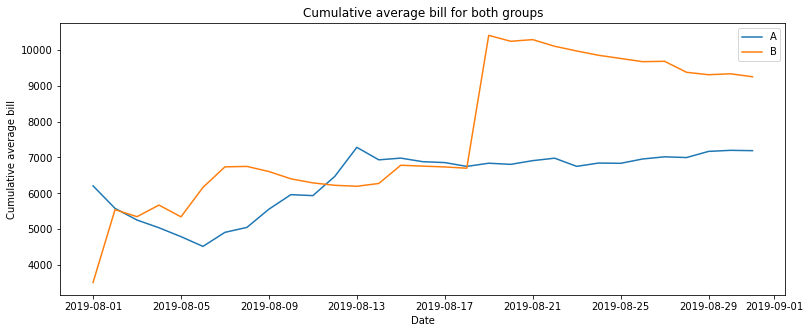

In [21]:
plt.figure(figsize=(13, 5))
plt.plot(cumulativeRevenueA['date'], 
         cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], 
         label='A')
plt.plot(cumulativeRevenueB['date'], 
         cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], 
         label='B')
plt.legend()
plt.ylabel('Cumulative average bill')
plt.xlabel('Date')
plt.title('Cumulative average bill for both groups')
plt.show()

A similar pattern is observed, with a sharp spike in Group B on August 18.

### Relative change in cumulative average bill of group B to group A

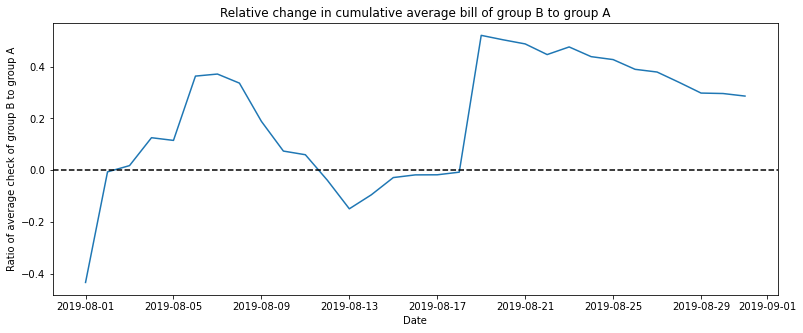

In [22]:
# combining datasets with cumulative revenue for both groups
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', 
                                                   right_on='date', 
                                                   how='left', 
                                                   suffixes=['A', 'B'])

# plotting the relation
plt.figure(figsize=(13, 5))
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--')

plt.title('Relative change in cumulative average bill of group B to group A')
plt.ylabel('Ratio of average check of group B to group A')
plt.xlabel('Date')
plt.show()

At several points the line jumped sharply (August 1, 5 and 18), most likely these are the days when abnormal orders were made.

### Cumulative average number of orders by groups

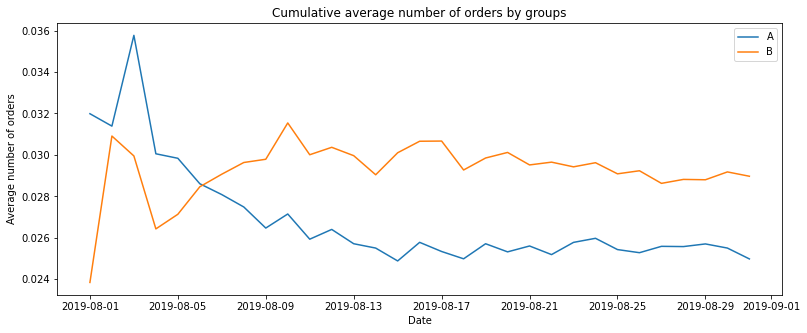

In [23]:
# number of orders per visitor
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# plotting average number of orders per visitor
plt.figure(figsize=(13, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

plt.title('Cumulative average number of orders by groups')
plt.ylabel('Average number of orders')
plt.xlabel('Date')
plt.show()

### Relative change in cumulative average number of orders in group B to group A

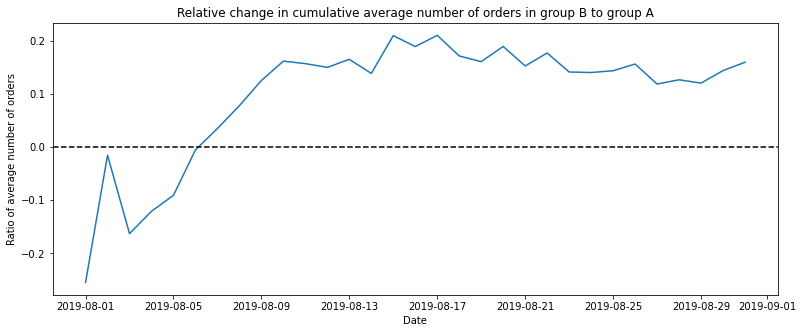

In [25]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B'])

plt.figure(figsize=(13, 5))
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')

plt.title('Relative change in cumulative average number of orders in group B to group A')
plt.ylabel('Ratio of average number of orders')
plt.xlabel('Date')
plt.show()

At the beginning of the test, group B was losing significantly to group A, then pulled ahead and on average kept at the same level.

### Number of orders per users

In [26]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False).agg(
        {'transactionId': 'nunique'}))

ordersByUsers.columns = ['visitorId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

      visitorId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


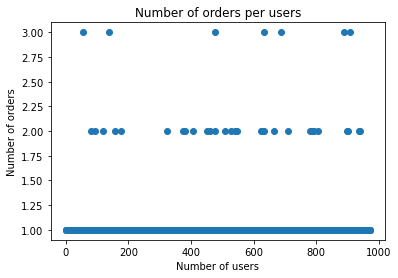

In [27]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Number of orders per users')
plt.ylabel('Number of orders')
plt.xlabel('Number of users')
plt.show()

The majority od users make only one order. Only a few of them made three orders.

95th and 99th percentiles of number of orders per user:

In [28]:
print('95th percentile: {:.3f}'.format(np.percentile(ordersByUsers['orders'], 95)))
print('99th percentile: {:.3f}'.format(np.percentile(ordersByUsers['orders'], 99)))

95th percentile: 1.000
99th percentile: 2.000


### Order price

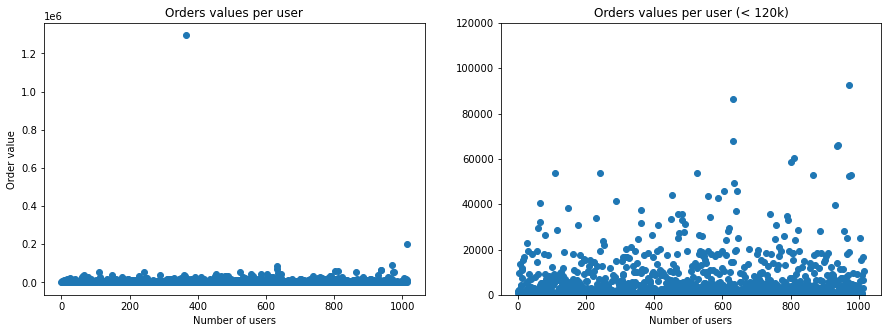

In [29]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.subplots(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
plt.scatter(x_values, orders['revenue'])
plt.title('Orders values per user')
plt.ylabel('Order value')
plt.xlabel('Number of users')

ax2 = plt.subplot(1, 2, 2)
plt.title('Orders values per user (< 120k)')
plt.xlabel('Number of users')
plt.scatter(x_values, orders['revenue'])
ax2.set_ylim(0, 120000)
plt.show()

In [30]:
print('95th percentile: {:.3f}'.format(np.percentile(orders['revenue'], 95)))
print('99th percentile: {:.3f}'.format(np.percentile(orders['revenue'], 99)))

95th percentile: 26785.000
99th percentile: 53904.000


We will count 1% of the values as abnormal and further consider orders with values up to 53,904.

### Statistical significance of differences between groups using raw data
* #### in the average number of orders

H0: There are no differences in the average number of orders between groups  
H1: There are differences in the average number of orders between groups

In [42]:
#group A(raw data)
#number of visitors per day 
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

#cumulative number of visitors per day
visitorsACumulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 
         'visitorsPerDateA': 'sum'}),
    axis=1)
visitorsACumulative.columns = ['date', 'visitorsCumulativeA']
visitorsACumulative.head()

,date,visitorsCumulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [43]:
#group B(raw data)
#number of visitors per day 
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

#cumulative number of visitors per day
visitorsBCumulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 
         'visitorsPerDateB': 'sum'}),
    axis=1)
visitorsBCumulative.columns = ['date', 'visitorsCumulativeB']
visitorsBCumulative.head()

,date,visitorsCumulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [44]:
#group A (raw data) 
#number of orders and their sum per day
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

#cumulative number of orders and their sum per day
ordersACumulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 
         'ordersPerDateA': 'sum', 
         'revenuePerDateA': 'sum'}),
    axis=1).sort_values(by=['date'])

ordersACumulative.columns = ['date','ordersCumulativeA','revenueCumulativeA']
ordersACumulative.head()

,date,ordersCumulativeA,revenueCumulativeA
0,2019-08-01,23,142779
1,2019-08-02,42,234381
2,2019-08-03,66,346854
3,2019-08-04,77,388030
4,2019-08-05,99,474413


In [45]:
#group B (raw data) 
#number of orders and their sum per day
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

#cumulative number of orders and their sum per day
ordersBCumulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 
         'ordersPerDateB': 'sum', 
         'revenuePerDateB': 'sum'}),
    axis=1).sort_values(by=['date'])
ordersBCumulative.columns = ['date','ordersCumulativeB','revenueCumulativeB']
ordersBCumulative.head()

,date,ordersCumulativeB,revenueCumulativeB
0,2019-08-01,17,59758
1,2019-08-02,40,221801
2,2019-08-03,54,288850
3,2019-08-04,68,385740
4,2019-08-05,89,475648


In [46]:
#merging all 8 datasets for both groups generated from raw data
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACumulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCumulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACumulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCumulative, left_on='date', right_on='date', how='left')
)
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCumulativeA,revenueCumulativeA,ordersCumulativeB,revenueCumulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCumulativeA,visitorsCumulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [47]:
#users from group A and their number of orders (preprocessed data)
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']
ordersByUsersA.head()

,userId,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


In [48]:
#users from group B and their number of orders (preprocessed data)
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']
ordersByUsersB.head()

,userId,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


Let's declare variables `sampleA` and `sampleB`, where users from different groups correspond to the number of orders. Those who have not ordered anything will have zeros.

In [49]:
sampleA = pd.concat(
    #number of orders made by users
    [ordersByUsersA['orders'],
     #number of orders is 0 for all other visitors (total visitors - buyers)
     pd.Series(0, index=np.arange(
         data['visitorsPerDateA'].sum() - len(ordersByUsersA)
     ), name='orders')
    ], axis=0)

In [55]:
sampleB = pd.concat(
    #number of orders made by users
    [ordersByUsersB['orders'],
     #number of orders is 0 for all other visitors (total visitors - buyers)
     pd.Series(0, index=np.arange(
         data['visitorsPerDateB'].sum() - len(ordersByUsersB)
     ), name='orders')
    ], axis=0)

In [56]:
#Applying Mann-Whitney test
print('P-value:', "{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))
print('Relative growth in the number of orders in group B:', "{0:.3f}"
      .format(sampleB.mean() / sampleA.mean() - 1))

P-value: 0.011
Relative growth in the number of orders in group B: 0.160


P-value is less than 0.05, i.e. the difference in the number of orders between two groups is statistically significant, we can reject the null hypothesis (since the probability of accidentally confirming the null hypothesis is only 1%).

* #### in the average bill

H0: There are no differences in the average bill between groups  
H1: There are differences in the average bill between groups

In [57]:
print('P-value:', '{0:.3f}'
      .format(st.mannwhitneyu(
          orders[orders['group']=='A']['revenue'], 
          orders[orders['group']=='B']['revenue'])[1]
             )
     )
print('The ratio of the bill in group B to group A', '{0:.3f}'
      .format(orders[orders['group']=='B']['revenue'].mean()/
              orders[orders['group']=='A']['revenue'].mean()-1)
     )

P-value: 0.829
The ratio of the bill in group B to group A 0.287


P-value is significantly greater than 0.05, there are no reasons to reject the null hypothesis, however, the average bill for group B is larger than group A. Since the relative difference in average bill between groups is ~28%, the observed differences are not significant at this level of significance and therefore were obtained by chance.

### Statistical significance of differences between groups using clean data
* #### in the average number of orders

From previous calculations:  
95th percentile of number of orders: 1  
99th percentile of number of orders: 2   
95th percentile of order's value: 26785.0  
99th percentile of order's value: 53904.0

Those who made more than 2 orders or orders that cost more than 53,904 are counted as anomalies.

In [58]:
max_orders = np.percentile(ordersByUsers['orders'], 99)
max_cost = np.percentile(orders['revenue'], 99)

usersWithManyOrders = pd.concat(
    [ordersByUsersA[ordersByUsersA['orders'] > max_orders]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > max_orders]['userId']
    ],
    axis=0)

usersWithExpensiveOrders = orders[orders['revenue'] > max_cost]['visitorId']

In [59]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64
16


In [60]:
sampleAFiltered = pd.concat(
    [ordersByUsersA[
        np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
     pd.Series(0,
               index=np.arange(
                   data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
               ), name='orders'),
    ], axis=0)

In [61]:
sampleBFiltered = pd.concat(
    [ordersByUsersB[
        np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
     pd.Series(0,
               index=np.arange(
                   data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
               ), name='orders')
    ], axis=0)

In [62]:
print('P-value: {0:.3f}'
      .format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Group B has more orders in: {0:.3f}'
      .format(sampleBFiltered.mean()/sampleAFiltered.mean()-1),'times')

P-value: 0.007
Group B has more orders in: 0.189 times


The p-value is also less than 0.05 as in the case with "raw" data, i.e. the difference in the number of orders remains statistically significant.
After getting rid of the anomalous values, group B is slightly ahead of group A by the average number of orders.

* #### in the average bill

In [63]:
print('P-value: {0:.3f}'.format(st.mannwhitneyu(
    orders[np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers))
    )]['revenue'],
    orders[np.logical_and(
        orders['group'] == 'B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers))
    )]['revenue'])[1]))

P-value: 0.788


In [64]:
print('The ratio of the bill in group B to group A: {0:.3f}'.format(
    orders[np.logical_and(
        orders['group'] == 'B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers))
    )]['revenue'].mean()/ orders[np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers))
    )]['revenue'].mean() - 1))

The ratio of the bill in group B to group A: -0.032


The p-value is still significantly greater than 0.05, there is no reason to reject the null hypothesis, but the average bill for group B is now smaller than group A.

Conclusions from the A/B analysis:
* the difference in average number of orders between the groups is statistically significant on both raw and clean data
* there is no statistically significant difference in the average order bill between the groups either in raw or clean data, although the ratio of the total order amount changes dramatically from a positive to a negative value.


## Overall conclusions:
1. Data was preprocessed, checked for duplicates, and users falling into both groups were removed.
2. Hypotheses were prioritized. The most promising were: 
- "Add two new channels to attract traffic, which will attract 30% more users", 
- "Add a subscription form to all main pages to collect a customer base for email newsletters"
3. A/B test has been conducted. The test should be stopped and the victory of group B should be recorded.
- in the case of the number of orders: with a probability of less than 1% we can randomly confirm the null hypothesis (the average number of orders between the groups is equal); the relative difference in the number of orders for group B is higher by ~17-19%
- in the case of the bill amount: p-value is much higher than 0.05 (we cannot refuse the null hypothesis); when analyzing the raw data, the bill amount for group B was 0.28 times higher, when analyzing cleaned data it was 0.03 times lower, i.e. it was almost equal to group A.